# Tests of exponentiating derivative operators

In this notebook we explore the accuracy of derivative operators realized as matrices on a coordinate space mesh and then do tests of exponentiating those operators various ways.

Standard imports plus seaborn (to make plots looks nicer).

In [2]:
import numpy as np
import scipy.linalg as la

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")


We'll define two functions that create matrices that implement approximate derivatives when applied to a vector made up of a function evaluated at the mesh points. The numpy `diag` and `ones` functions are used to create matrices with 1's on particular diagonals, as in these $5\times 5$ examples of forward derivatives (left) and symmetric derivatives (right):

$$ \frac{1}{\Delta x}\,\left( 
    \begin{array}{ccccc}
    -1 & 1 & 0 & 0 & 0 \\
    0 & -1 & 1 & 0 & 0 \\
    0 & 0 & -1 & 1 & 0 \\
    0 & 0 &0 & -1 & 1 \\
    0 & 0 & 0 & 0 & -1
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right)
   \qquad\qquad
   \frac{1}{2\Delta x}\,\left( 
    \begin{array}{ccccc}
    0 & 1 & 0 & 0 & 0 \\
    -1 & 0 & 1 & 0 & 0 \\
    0 & -1 & 0 & 1 & 0 \\
    0 & 0 & -1 & 0 & 1 \\
    0 & 0 & 0 & -1 & 0
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right)
 $$   

In [3]:
def forward_derivative_matrix(Nc, Delta_x):
    """Return an Nc x Nc matrix for derivative of an equally spaced vector by delta_x
    """
    return ( np.diag(np.ones(Nc-1), +1) - np.diag(np.ones(Nc), 0) ) / Delta_x

In [4]:
def symmetric_derivative_matrix(Nc, Delta_x):
    """Return an Nc x Nc matrix for derivative of an equally spaced vector by delta_x
    """
    return ( np.diag(np.ones(Nc-1), +1) - np.diag(np.ones(Nc-1), -1) ) / (2 * Delta_x)

## Testing forward derivative

In [5]:
Nc = 101;
x_min = 0.
x_max = 2.
Delta_x = (x_max - x_min) / (Nc - 1)
x_mesh = np.linspace(x_min, x_max, Nc)

In [6]:
# Check that mesh is consistent with Delta_x
print(Delta_x)
#print(x_mesh)

0.02


In [7]:
fd = forward_derivative_matrix(Nc, Delta_x)
sd = symmetric_derivative_matrix(Nc, Delta_x)

In [8]:
# f_test = (np.sin(x_mesh))**2
# f_deriv_exact = 2 * np.cos(x_mesh) * np.sin(x_mesh)

In [9]:
def f_test_1(x_mesh):
    return (np.exp(-x_mesh) * x_mesh**4, (4 * x_mesh**3 - x_mesh**4) * np.exp(-x_mesh))

In [10]:
f_test, f_deriv_exact = f_test_1(x_mesh)

In [11]:
f_deriv_fd = fd @ f_test
f_deriv_sd = sd @ f_test

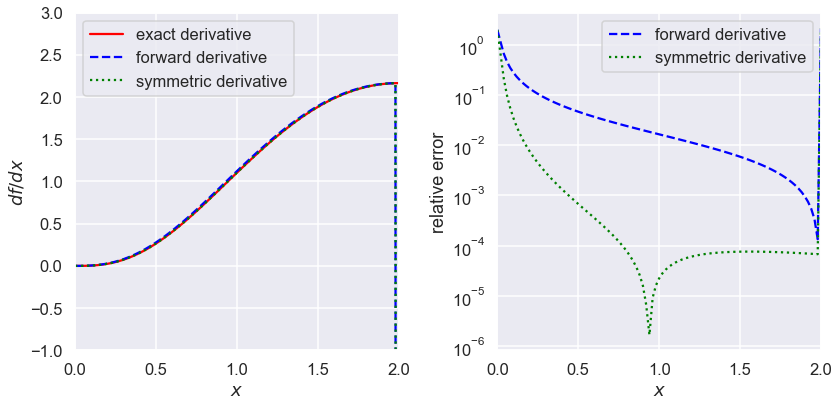

In [12]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$df/dx$')
ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_deriv_exact, color='red', label='exact derivative')
ax1.plot(x_mesh, f_deriv_fd, color='blue', label='forward derivative', linestyle='dashed')
ax1.plot(x_mesh, f_deriv_sd, color='green', label='symmetric derivative', linestyle='dotted')

#ax.set_title(f'{test_ho.V_string} with k_osc = {k_osc:.1f}, mass = {mass:.1f}')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)
#ax2.set_ylim(-0.001, 0.001)

rel_error_fd = 2 * (f_deriv_exact - f_deriv_fd) / (f_deriv_exact + f_deriv_fd)
rel_error_sd = 2 * (f_deriv_exact - f_deriv_sd) / (f_deriv_exact + f_deriv_sd)

ax2.semilogy(x_mesh, np.abs(rel_error_fd), color='blue', label='forward derivative', linestyle='dashed')
ax2.semilogy(x_mesh, np.abs(rel_error_sd), color='green', label='symmetric derivative', linestyle='dotted')

#ax.set_title(f'{test_ho.V_string} with k_osc = {k_osc:.1f}, mass = {mass:.1f}')
ax2.legend()

fig.tight_layout()

## Exponentiating derivative matrix for finite translation

In [13]:
a = 5 * Delta_x

In [14]:
f_exp_exact, dummy  = f_test_1(x_mesh + a)
f_exp_fd = la.expm(a*fd) @ f_test
f_exp_sd = la.expm(a*sd) @ f_test
f_exp_fd2 = la.fractional_matrix_power(np.eye(Nc) + Delta_x*fd, a/Delta_x) @ f_test
f_exp_sd2 = la.fractional_matrix_power(np.eye(Nc) + Delta_x*sd, a/Delta_x) @ f_test

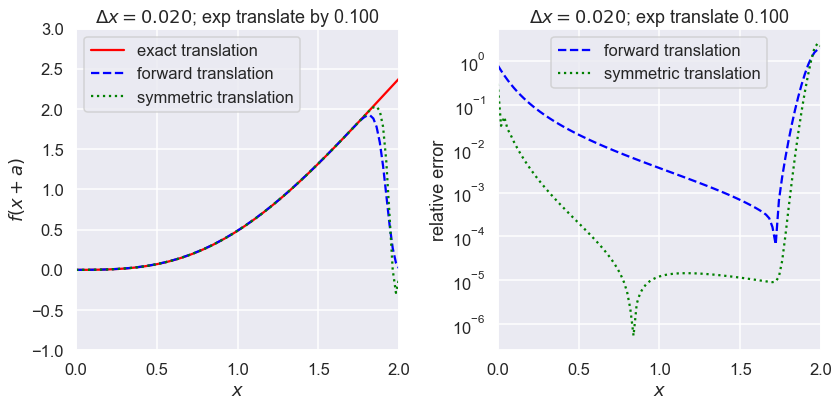

In [18]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$f(x+a)$')
ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_exp_exact, color='red', label='exact translation')
ax1.plot(x_mesh, f_exp_fd, color='blue', label='forward translation', linestyle='dashed')
ax1.plot(x_mesh, f_exp_sd, color='green', label='symmetric translation', linestyle='dotted')

ax1.set_title(fr'$\Delta x = {Delta_x:.3f}$; exp translate by {a:.3f}')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)
#ax2.set_ylim(-0.001, 0.001)

rel_error_fd = 2 * (f_exp_exact - f_exp_fd) / (f_exp_exact + f_exp_fd)
rel_error_sd = 2 * (f_exp_exact - f_exp_sd) / (f_exp_exact + f_exp_sd)

ax2.semilogy(x_mesh, np.abs(rel_error_fd), color='blue', label='forward translation', linestyle='dashed')
ax2.semilogy(x_mesh, np.abs(rel_error_sd), color='green', label='symmetric translation', linestyle='dotted')

ax2.set_title(fr'$\Delta x = {Delta_x:.3f}$; exp translate {a:.3f}')
ax2.legend()

fig.tight_layout()

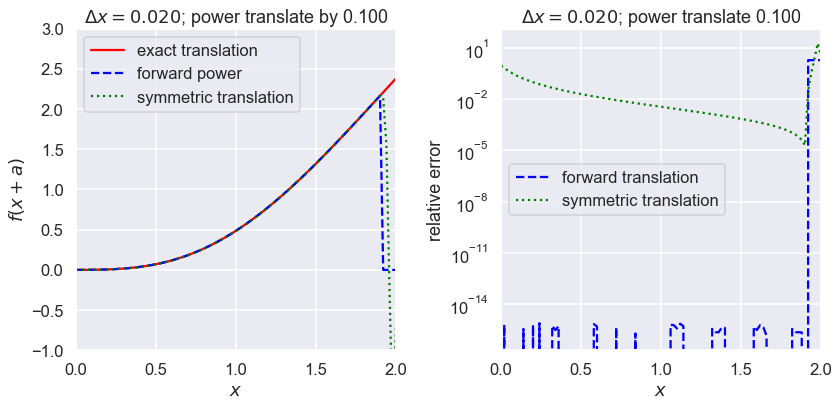

In [21]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$f(x+a)$')
ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_exp_exact, color='red', label='exact translation')
ax1.plot(x_mesh, f_exp_fd2, color='blue', label='forward power', linestyle='dashed')
ax1.plot(x_mesh, f_exp_sd2, color='green', label='symmetric translation', linestyle='dotted')

ax1.set_title(fr'$\Delta x = {Delta_x:.3f}$; power translate by {a:.3f}')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)

rel_error_fd = 2 * (f_exp_exact - f_exp_fd2) / (f_exp_exact + f_exp_fd2)
rel_error_sd = 2 * (f_exp_exact - f_exp_sd2) / (f_exp_exact + f_exp_sd2)

ax2.semilogy(x_mesh, np.abs(rel_error_fd), color='blue', label='forward translation', linestyle='dashed')
ax2.semilogy(x_mesh, np.abs(rel_error_sd), color='green', label='symmetric translation', linestyle='dotted')

ax2.set_title(fr'$\Delta x = {Delta_x:.3f}$; power translate {a:.3f}')
ax2.legend()

fig.tight_layout()

## Scaling of error with $\Delta x$

To understand the results, we need to trace what happens to the error we make with each approach.